In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split # Can use this for a quick validation set
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import math

# Add project root to sys.path
project_root = Path.cwd().parent # Should be RECSYS_FINAL
sys.path.append(str(project_root))

# Import project modules
from src import config
from src.data.dataset import CFDataset, create_mappings_and_unique_ids # Import dataset class and helper
from src.models.ncf import NCF # Import the NCF model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Using device: cpu


In [18]:
# Load the final aggregated interactions data
interactions_path = config.PROCESSED_DATA_DIR / "interactions_final.parquet"
try:
    interactions_df = pd.read_parquet(interactions_path)
    print(f"Loaded interactions data shape: {interactions_df.shape}")
    print(interactions_df.head())
except FileNotFoundError:
    print(f"Error: {interactions_path} not found.")
    print("Please ensure the preprocessing pipeline (run_preprocessing.py) has run successfully.")
    raise

Loaded interactions data shape: (28466, 7)
   id_student presentation_id  total_clicks  interaction_days  \
0        6516       AAA_2014J          2791               159   
1        8462       DDD_2013J           646                56   
2        8462       DDD_2014J            10                 1   
3       11391       AAA_2013J           934                40   
4       23629       BBB_2013B           161                16   

   first_interaction_date  last_interaction_date  implicit_feedback  
0                     -23                    269           7.934513  
1                      -6                    118           6.472346  
2                      10                     10           2.397895  
3                      -5                    253           6.840547  
4                      -6                     87           5.087596  


In [19]:
# Define column names
USER_COL = 'id_student'
ITEM_COL = 'presentation_id'

# Create mappings from original IDs to contiguous indices
user_id_map, item_id_map, unique_users, unique_items = create_mappings_and_unique_ids(
    interactions_df, USER_COL, ITEM_COL
)
n_users = len(unique_users)
n_items = len(unique_items)

print(f"Number of unique users: {n_users}")
print(f"Number of unique items: {n_items}")

# Split interactions data (optional, for quick validation during training)
# Using a simple random split here just for dev purposes.
# The final evaluation will use the proper time-based split test_df.
train_interactions, val_interactions = train_test_split(
    interactions_df, test_size=0.1, random_state=config.RANDOM_SEED
)
print(f"Train interactions shape: {train_interactions.shape}")
print(f"Validation interactions shape: {val_interactions.shape}")

# Create Datasets (using the full mappings created from the whole interactions_df)
# Training dataset WITH negative sampling
train_dataset = CFDataset(
    interactions_df=train_interactions,
    all_item_ids=unique_items.tolist(), # Pass all unique items
    user_id_map=user_id_map,
    item_id_map=item_id_map,
    user_col=USER_COL,
    item_col=ITEM_COL,
    num_negatives=4 # Example: 4 negative samples per positive
)

# Validation dataset WITHOUT negative sampling (only positive interactions)
# We will predict scores for these and compare against a threshold or use ranking metrics
val_dataset = CFDataset(
    interactions_df=val_interactions,
    all_item_ids=unique_items.tolist(),
    user_id_map=user_id_map,
    item_id_map=item_id_map,
    user_col=USER_COL,
    item_col=ITEM_COL,
    num_negatives=0 # No negative sampling for validation of positives
)

# Create DataLoaders
BATCH_SIZE = 1024 # Adjust based on memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=4, pin_memory=True) # Usually larger batch size for validation

print(f"\nDataLoaders created with batch size: {BATCH_SIZE} (train), {BATCH_SIZE*2} (val)")

Number of unique users: 25364
Number of unique items: 22
Train interactions shape: (25619, 7)
Validation interactions shape: (2847, 7)
Preparing CFDataset...
Dataset contains 25619 positive interactions.
Generating 4 negative samples per positive interaction.
CFDataset preparation complete.
Preparing CFDataset...
Dataset contains 2847 positive interactions.
CFDataset preparation complete.

DataLoaders created with batch size: 1024 (train), 2048 (val)


In [20]:
# Cell [4] (Modified for Weight Decay and 2 Epochs)

# Model Hyperparameters (adjust as needed)
MF_DIM = 32
MLP_EMBEDDING_DIM = 32
MLP_LAYERS = [64, 32, 16, 8] # Input layer (2*MLP_EMBEDDING_DIM = 64) -> 32 -> 16 -> 8
DROPOUT = 0.2

# Learning Rate and Epochs
LEARNING_RATE = 0.001
EPOCHS = 2 # TRAIN FOR ONLY 2 EPOCHS (based on previous validation results)
WEIGHT_DECAY = 1e-5 # Regularization

# Initialize NCF model
model = NCF(
    n_users=n_users,
    n_items=n_items,
    mf_dim=MF_DIM,
    mlp_layers=MLP_LAYERS,
    mlp_embedding_dim=MLP_EMBEDDING_DIM,
    dropout=DROPOUT
).to(device)

# Loss Function (handles logits directly)
criterion = nn.BCEWithLogitsLoss()

# Optimizer WITH WEIGHT DECAY
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print("Model, Criterion, and Optimizer initialized.")
# print(model) # Optional: Can uncomment to see architecture again

Initializing NCF Model...
 GMF Embedding Dim: 32
 MLP Embedding Dim: 32
 MLP Layers: [64, 32, 16, 8]
 NeuMF Input Dim: 40 (MF=32 + MLP=8)
NCF Model Initialized.
Model, Criterion, and Optimizer initialized.


In [21]:
# Training Loop
print("\n--- Starting NCF Training ---")
train_losses = []
val_losses = [] # Basic validation loss (on positive samples only)

for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for users, items, labels in progress_bar:
        # Move data to device
        users, items, labels = users.to(device), items.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(users, items)

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()}) # Show loss for current batch

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_epoch_loss:.4f}")

    # --- Basic Validation ---
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for users, items in val_loader: # Val dataset only yields user, item
            users, items = users.to(device), items.to(device)
            # Create labels (all 1s for positive validation samples)
            labels = torch.ones(users.size(0), device=device)
            logits = model(users, items)
            loss = criterion(logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss:.4f}")

print("--- NCF Training Finished ---")


--- Starting NCF Training ---


Epoch 1/2:   0%|          | 0/126 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 1/2 - Training Loss: 0.5691
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Dat

Epoch 2/2:   0%|          | 0/126 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 2/2 - Training Loss: 0.5001
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Dat

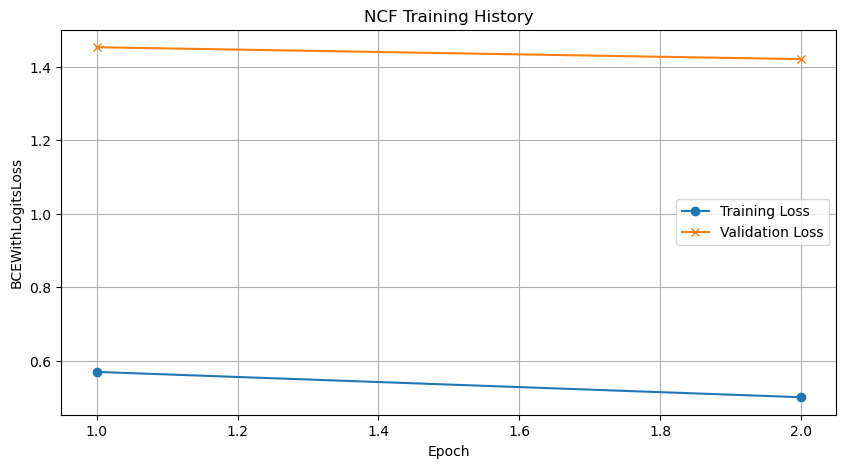

In [22]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, marker='x', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.title("NCF Training History")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Cell [7] - Evaluate NCF Model (Corrected WITH Imports)

import pandas as pd
import numpy as np
import torch
from pathlib import Path
import sys

# --- Ensure project root is in sys.path ---
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
# -----------------------------------------

# --- Import necessary functions/classes ---
from src import config
from src.data import preprocess # For time_based_split
from src.evaluation.evaluator import RecEvaluator # <<< IMPORT RecEvaluator
#------------------------------------------

# --- Ensure necessary variables are defined (Check before proceeding) ---
if 'model' not in locals(): raise NameError("NCF model 'model' not defined. Run training cell first.")
if 'user_id_map' not in locals(): raise NameError("'user_id_map' not defined. Run cell [3] first.")
if 'item_id_map' not in locals(): raise NameError("'item_id_map' not defined. Run cell [3] first.")
#-----------------------------------------------

# --- Load or Recreate the CORRECT Time-Based Train/Test Split ---
# Using Option 2: Recreate the split (ensure consistency with baselines)
print("Recreating time-based split for evaluation...")
interactions_path_eval = config.PROCESSED_DATA_DIR / "interactions_final.parquet"
if 'interactions_df' not in locals(): # Load if not already in memory from cell [2]
    if not interactions_path_eval.exists():
         raise FileNotFoundError(f"Cannot find {interactions_path_eval}. Run preprocessing first.")
    interactions_df = pd.read_parquet(interactions_path_eval)

TIME_THRESHOLD = 250 # <<< Make sure this is the same threshold used in 03_baseline_models!
train_df_eval, test_df_eval = preprocess.time_based_split(
    interactions_df=interactions_df,
    user_col='id_student',
    item_col='presentation_id',
    time_col='last_interaction_date',
    time_unit_threshold=TIME_THRESHOLD
)
print(f"Time-based split recreated. Train: {train_df_eval.shape}, Test: {test_df_eval.shape}")
#-----------------------------------------------------------------

# --- Load Item Features ---
items_df_path = config.PROCESSED_DATA_DIR / "items_final.parquet"
if 'items_df' not in locals() or (isinstance(items_df, pd.DataFrame) and items_df.index.name != 'presentation_id'):
     print("Loading items_df...")
     items_df = pd.read_parquet(items_df_path)
     if 'presentation_id' in items_df.columns:
        items_df = items_df.set_index('presentation_id')
     else:
        raise ValueError("Items DataFrame must have 'presentation_id' column.")
elif not isinstance(items_df, pd.DataFrame): # Check if it was somehow overwritten
     raise TypeError("items_df is not a DataFrame.")
print("Items DataFrame ready.")
#-----------------------------------------------------------------

# --- Wrap the NCF model ---
class NCFEvaluatorWrapper:
    def __init__(self, ncf_model, user_map, item_map):
        self.model = ncf_model
        self.user_id_to_idx = user_map
        self.item_id_to_idx = item_map
        self.device = next(ncf_model.parameters()).device

    def predict(self, user_id, item_ids):
        """ Predicts scores for original user/item IDs """
        user_idx = self.user_id_to_idx.get(user_id)
        if user_idx is None: return np.zeros(len(item_ids))
        item_idxs = [self.item_id_to_idx.get(iid, -1) for iid in item_ids]
        valid_item_indices_eval = [idx for idx in item_idxs if idx != -1]
        original_pos_map = {idx: i for i, idx in enumerate(item_idxs) if idx != -1}
        if not valid_item_indices_eval: return np.zeros(len(item_ids))
        user_tensor_eval = torch.tensor([user_idx] * len(valid_item_indices_eval), dtype=torch.long)
        item_tensor_eval = torch.tensor(valid_item_indices_eval, dtype=torch.long)
        scores_known_items = self.model.predict(user_tensor_eval, item_tensor_eval) # Use model's predict
        final_scores = np.zeros(len(item_ids))
        for valid_idx, score in zip(valid_item_indices_eval, scores_known_items):
            original_pos = original_pos_map.get(valid_idx)
            if original_pos is not None: final_scores[original_pos] = score
        return final_scores
#-----------------------------------------------------------------

# Wrap the *trained* NCF model (variable named 'model' from cell [5])
ncf_eval_wrapper = NCFEvaluatorWrapper(model, user_id_map, item_id_map)
print("NCF model wrapped for evaluator.")

# --- Initialize Evaluator and Evaluate ---
if test_df_eval.empty:
    print("\nCannot evaluate NCF model: Test data (time-split) is empty.")
else:
    print(f"\nInitializing evaluator with Train: {train_df_eval.shape}, Test: {test_df_eval.shape}")
    ncf_evaluator = RecEvaluator( # <<< RecEvaluator should now be defined
        train_df=train_df_eval,
        test_df=test_df_eval,
        item_features_df=items_df,
        user_col='id_student',
        item_col='presentation_id',
        k=config.TOP_K
    )

    # Evaluate the NCF model
    print("\n--- Starting Evaluation of NCF Model (Trained for 2 Epochs) ---")
    ncf_results = ncf_evaluator.evaluate_model(ncf_eval_wrapper, n_neg_samples=100)

    print("\nNCF Model Evaluation Results:")
    print(ncf_results)
#-----------------------------------------------------------------

Recreating time-based split for evaluation...
Performing time-based split...
Original interactions shape: (28466, 7)
Splitting based on time threshold: last_interaction_date <= 250
 Initial train size: 22892, Initial test size: 5574
Filtered 4836 interactions from test set (users/items not in train).
Final Training set shape: (22892, 7)
Final Test set shape: (738, 7)
Users in Train: 20701, Users in Test: 731
Items in Train: 22, Items in Test: 13
Time-based split recreated. Train: (22892, 7), Test: (738, 7)
Items DataFrame ready.
NCF model wrapped for evaluator.

Initializing evaluator with Train: (22892, 7), Test: (738, 7)
Evaluator initialized with 22 unique candidate items.
Stored 20701 training interactions for filtering.
Prepared test data for 731 users.

--- Starting Evaluation of NCF Model (Trained for 2 Epochs) ---

--- Evaluating Model: NCFEvaluatorWrapper ---


AttributeError: 'NCFEvaluatorWrapper' object has no attribute 'get_known_items'